# IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from sklearn.model_selection import train_test_split
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREPARATION WITH PANDAS

In [ ]:
# Load Dataset WebMD Drug Reviews Dataset
df_pandas = pd.read_csv('/content/drive/MyDrive/DatasetPJBLBD/webmd.csv')
df_pandas.info() # Menampilkan Informasi Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362763 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [ ]:
# Mengecek Nilai NaN Pada DataFrame
df_pandas.isnull().sum()

,0
Age,0
Condition,0
Date,0
Drug,0
DrugId,0
EaseofUse,0
Effectiveness,0
Reviews,43
Satisfaction,0
Sex,0


In [ ]:
# Mengubah Nilai yang Hanya Berisi Newline atau Kosong Menjadi NaN
df_pandas['Reviews'] = df_pandas['Reviews'].apply(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x)

# Melihat Jumlah Nilai NaN pada DataFrame
df_pandas.isna().sum()

,0
Age,0
Condition,0
Date,0
Drug,0
DrugId,0
EaseofUse,0
Effectiveness,0
Reviews,41889
Satisfaction,0
Sex,0


In [ ]:
# Menghapus Baris yang Memiliki Nilai NaN alam Kolom 'Reviews'
df_pandas = df_pandas.dropna(subset=['Reviews'])

# Mengecek Nilai NaN Pada DataFrame
df_pandas.isna().sum()

,0
Age,0
Condition,0
Date,0
Drug,0
DrugId,0
EaseofUse,0
Effectiveness,0
Reviews,0
Satisfaction,0
Sex,0


In [ ]:
# Mengonversi Kolom 'Satisfaction' Menjadi Sentimen (1 = Positive, 0 = Negative)
df_pandas['sentiment'] = df_pandas['Satisfaction'].apply(lambda x: 1 if x >= 3 else 0)

# Memeriksa Hasil Konversi
print(df_pandas[['Satisfaction', 'sentiment']].head())

   Satisfaction  sentiment
0             5          1
1             5          1
2             3          1
3             1          0
4             1          0


# MODELING DATA WITH SPARK

In [ ]:
# Inisialisasi Spark Session
spark = SparkSession.builder.appName('WebMD Drug Sentiment Analysis').getOrCreate()
df = spark.createDataFrame(df_pandas)

# Menampilkan Data 5 Teratas
df.show(5)

+----------+-------------+---------+--------------------+------+---------+-------------+--------------------+------------+------+--------------------+-----------+---------+
|       Age|    Condition|     Date|                Drug|DrugId|EaseofUse|Effectiveness|             Reviews|Satisfaction|   Sex|               Sides|UsefulCount|sentiment|
+----------+-------------+---------+--------------------+------+---------+-------------+--------------------+------------+------+--------------------+-----------+---------+
|75 or over|  Stuffy Nose|9/21/2014|        25dph-7.5peh|146724|        5|            5|I'm a retired phy...|           5|  Male|Drowsiness,  dizz...|          0|        1|
|     25-34|Cold Symptoms|1/13/2011|        25dph-7.5peh|146724|        5|            5|cleared me right ...|           5|Female|Drowsiness,  dizz...|          1|        1|
|     65-74|        Other|7/16/2012|warfarin (bulk) 1...|144731|        2|            3|why did my PTINR ...|           3|Female|      

In [ ]:
# Memecah Teks Menjadi Kata Pada Kolom "Reviews"
tokenizer = Tokenizer(inputCol="Reviews", outputCol="words")

# Mengukur seberapa sering suatu kata muncul dalam sebuah dokumen tertentu.
hashing_tf = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=5000)

# Mengukur seberapa penting kata tersebut dalam keseluruhan kumpulan dokumen.
idf = IDF(inputCol="raw_features", outputCol="features")

# Merangkai Tokenizer, HashingTF, dan IDF Menjadi Satu Alur.
pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf])

# Model Pipeline Dilatih Untuk Menghasilkan Fitur TF-IDF
model = pipeline.fit(df)
df_tfidf = model.transform(df)

# Menampilkan Hasil TF-IDF
df_tfidf.select("Reviews", "features").show()

# Mengambil Fitur dan Label (Target)
data = df_tfidf.select("features", "sentiment")

+--------------------+--------------------+
|             Reviews|            features|
+--------------------+--------------------+
|I'm a retired phy...|(5000,[76,150,177...|
|cleared me right ...|(5000,[397,568,10...|
|why did my PTINR ...|(5000,[345,440,48...|
|FALLING AND DON'T...|(5000,[394,2891,3...|
|My grandfather wa...|(5000,[38,92,313,...|
|help heart condit...|(5000,[157,328,92...|
|Haven't gotten pr...|(5000,[288,343,37...|
|I have take this ...|(5000,[307,373,43...|
|The 12 hour spray...|(5000,[263,527,10...|
|Excellent in redu...|(5000,[452,2371,2...|
|Taking Lyza made ...|(5000,[34,125,134...|
|This stuff needs ...|(5000,[14,44,209,...|
|I usually have ze...|(5000,[165,285,37...|
|I was concerned a...|(5000,[113,165,30...|
|The birth control...|(5000,[79,133,139...|
|LYZA BIRTH CONTRO...|(5000,[14,113,209...|
|Iâ??ve been takin...|(5000,[14,66,102,...|
|I have been takin...|(5000,[38,88,165,...|
|I have been on th...|(5000,[66,76,89,1...|
|I took this pill ...|(5000,[15,

In [ ]:
# Membagi Data Menjadi Data Latih dan Data Uji
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Menampilkan Jumlah Data Latih dan Data Uji
print(f"Jumlah Training Data: {train_data.count()}")
print(f"Jumlah Testing Data: {test_data.count()}")

Jumlah Training Data: 256726
Jumlah Testing Data: 64191


In [ ]:
# Menyiapkan Model Random Forest Untuk Klasifikasi
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="sentiment", numTrees=100, seed=42)

# Melatih Model dengan Data Latih
rf_model = rf_classifier.fit(train_data)

In [ ]:
# Melakukan Prediksi dengan Data Uji
predictions = rf_model.transform(test_data)

# Mengevaluasi Model Menggunakan Akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Menampilkan Hasil Akurasi
print(f"Akurasi Model Random Forest Classifier : {accuracy}")

Akurasi Model Random Forest Classifier : 0.6006293717187767


# HYPERPARAMETER TUNING

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# maxDepth: Mengatur Kedalaman Maksimum Pohon Keputusan Pada Model Random Forest Classifier.
# numTrees: Mengatur Jumlah Pohon dalam Model Random Forest Classifier.
paramGrid = ParamGridBuilder()\
    .addGrid(rf_classifier.maxDepth, [5, 10])\
    .addGrid(rf_classifier.numTrees, [50, 100])\
    .build()

# estimator: Model yang Digunakan, estimatorParamMaps: Grid Hyperparameter, numFolds: Pembagian Data
crossval = CrossValidator(estimator=rf_classifier, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cv_model = crossval.fit(train_data)

# Evaluasi Model dengan Cross-Validation
cv_predictions = cv_model.transform(test_data)
cv_accuracy = evaluator.evaluate(cv_predictions)
print(f'Akurasi Model Random Forest Classifier dengan Cross-Validation: {cv_accuracy}')

# Menampilkan Hasil Prediksi Cross-Validation 10 Data Teratas
predictions_crossval = cv_predictions.select("sentiment", "prediction").toPandas()
print("\nHasil Prediksi Menggunakan Cross Validation:")
predictions_crossval.head(10)

Akurasi Model Random Forest Classifier dengan Cross-Validation: 0.6218784564814382

Hasil Prediksi Menggunakan Cross Validation:


,sentiment,prediction
0,1,1.0
1,1,1.0
2,1,0.0
3,1,1.0
4,1,1.0
5,1,1.0
6,1,1.0
7,1,1.0
8,0,1.0
9,0,1.0


# TESTING DATA WITH NEW REVIEWS

In [ ]:
# Menyiapkan Data Ulasan Baru
new_review = ["I feel so much better after taking this medication!"]

# Membuat DataFrame dari Ulasan Baru
new_df = spark.createDataFrame([(review,) for review in new_review], ["Reviews"])

# Menjalankan Pipeline Pada Ulasan Baru
new_data = model.transform(new_df)

# Melakukan Prediksi Pada Ulasan Baru
test_predictions = cv_model.transform(new_data)

# Mengambil Hasil Prediksi
predicted_sentiment = predictions.select("prediction").collect()[0][0]

# Menampilkan Hasil Prediksi
print(f"Prediksi Sentiment Reviews Terbaru {new_review} :", "Positive" if predicted_sentiment == 1 else "Negative")

Prediksi Sentiment Reviews Terbaru ['I feel so much better after taking this medication!'] : Positive


In [ ]:
# Menyiapkan Data Ulasan Baru
new_review1 = ["I feel so much better after taking this medication!"]

# Membuat DataFrame dari Ulasan Baru
new_df1 = spark.createDataFrame([(review,) for review in new_review1], ["Reviews"])

# Menjalankan Pipeline Pada Ulasan Baru
new_data1 = model.transform(new_df1)

# Melakukan Prediksi Pada Ulasan Baru
test_predictions1 = cv_model.transform(new_data1)

# Mengambil Hasil Prediksi
predicted_sentiment1 = predictions1.select("prediction").collect()[0][0]

# Menampilkan Hasil Prediksi
print(f"Prediksi Sentiment Reviews Terbaru {new_review1} :", "Positive" if predicted_sentiment1 == 1 else "Negative")

Prediksi Sentiment Reviews Terbaru ['I feel so much better after taking this medication!'] : Positive


# DATA VISUALIZATION

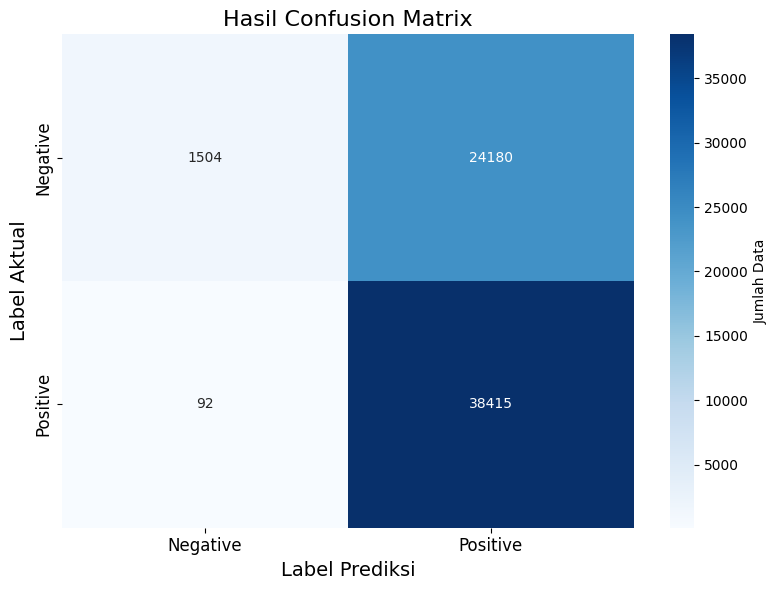

In [ ]:
# Mengambil Hasil Prediksi
predictions_pd = cv_predictions.select("sentiment", "prediction").toPandas()

# Membuat Confusion Matrix
conf_matrix = pd.crosstab(predictions_pd['sentiment'], predictions_pd['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Inisialisasi Label Matrix
labels = ['Negative', 'Positive']

# Membuat Visualisasi Confusion Matrix (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels,
            yticklabels=labels, cbar_kws={'label': 'Jumlah Data'})
plt.title('Hasil Confusion Matrix', fontsize=16)
plt.xlabel('Label Prediksi', fontsize=14)
plt.ylabel('Label Aktual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Menampilkan Visualisasi
plt.show()

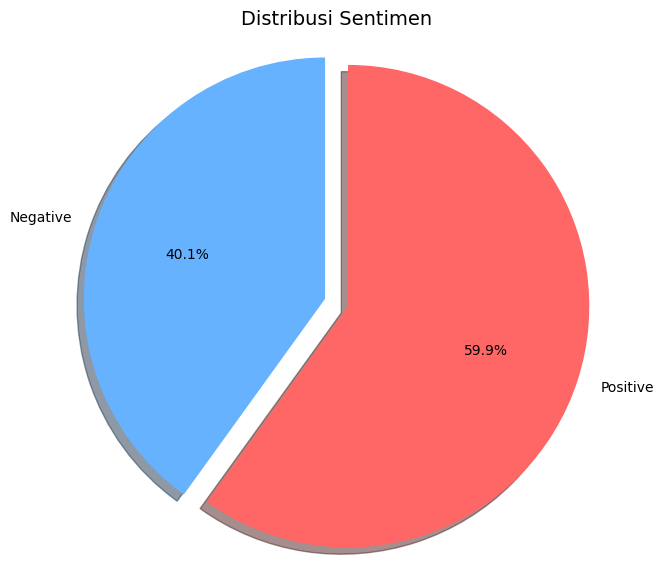

In [ ]:
# Menghitung Jumlah Sentiment
sentiment_counts = df_tfidf.select("sentiment").groupBy("sentiment").count().toPandas()
sentiment_counts = sentiment_counts.sort_values("sentiment")

# Data Untuk Diagram Pie Chart
sizes = sentiment_counts["count"].values

# Membuat Visualisasi Distribusi Sentimen (Pie Chart)
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=['Negative', 'Positive'], autopct='%1.1f%%',
        startangle=90, colors=['#66B2FF', '#FF6666'], explode=(0.1, 0),
        shadow=True, textprops={'color': 'black'})
plt.title('Distribusi Sentimen', fontsize=14)
plt.axis('equal')

# Menampilkan Visualisasi
plt.show()

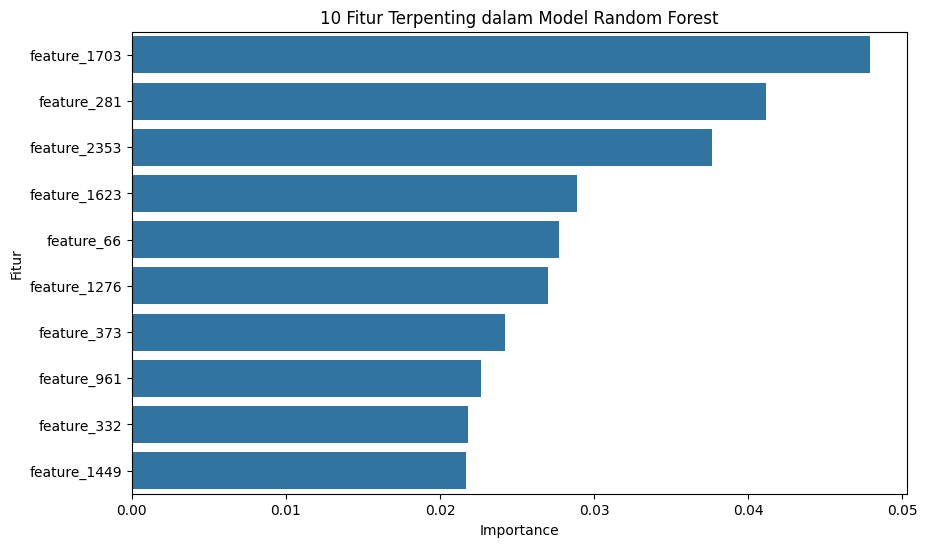

In [ ]:
# Mengambil feature importances dari model Random Forest
importances = rf_model.featureImportances.toArray()

# Mendapatkan nama fitur
feature_names = [f"feature_{i}" for i in range(len(importances))]

# Membuat DataFrame untuk menggabungkan fitur dengan importance-nya
features_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Mengurutkan berdasarkan importance
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Menampilkan 10 fitur terpenting
top_10_features = features_importance_df.head(10)

# Visualisasi 10 fitur terpenting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('10 Fitur Terpenting dalam Model Random Forest')
plt.xlabel('Importance')
plt.ylabel('Fitur')
plt.show()
